# Kaggle の Kicksteter 問題
- かがわAIゼミナール基礎編の後半の課題として取り組む
- KaggleのKickstarter Projectsの2018年データを利用 https://www.kaggle.com/kemical/kickstarter-projects/

## DAY1
- 大まかな方針として，nameの文字数，category, main_category, deadline, launched, country を説明変数とし，usd_pledged_realを線形モデルで推定．そして推定結果をusd_goal_realと比較することでプロジェクトの成否を判定した．
- 結果，59.138%の正答率が得られた．

## DAY1で受けたフィードバック
- name列の文字数以外の利用法を検討しては？
- usd_pledged_realをそのまま使うとばらつきが大きいので対数変換や標準化を試しては？
- 次は、グラフを描いてみて、データの特徴を捉えましょう。

## DAY2
- 前処理として標準化を適用した
- usd_pledged_realを対数変換して考えると，標準化がきれいに効くようになった．
- countryはほとんどUSなので，まずUSだけを対象としたモデルを作ってみた．（これで無理なら全部では到底無理）
- categoryで一番多いのはProduct Designなので，まず Product Design (main categoryはDesin)だけを対象としたモデルを作ってみた．（これで無理なら複数カテでも当然苦しい）
- 汎化誤差を評価した。アンダーフィットだったので正則化までするに至らなかった．
- 多項式モデルを適用してみた（説明変数同士を掛け合わせた二次の項を説明変数に追加，5次まで追加）
- name列の文字数以外の利用法検討
    - 山崎さんのアイデアを真似て，nameのスペース数を説明変数に加えた


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.pipeline import make_pipeline

# 1. データの読み込み・確認
- データを読み込んだ
- 基本の情報，いくつかのデータ例，散布図行列を見た
    - 15の列があることが分かった
    - 378661個のデータがあることが分かった
    - "name"と"usd_pledged"に欠損値があることが分かった．
        - プロジェクト名の欠損値は少ないので省いて問題なさそう
        - usd_pledgedも欠損数は1%程度なので省いても問題ない．他の項目から推定できるかもしれない．
        - usd_pledgedは予想には使えないデータなのであまり問題はない可能性が高い．（ただ，ここを線形回帰で予想して，goalと比較したら成否を判定できる意味では利用価値がないとは言えない）

In [2]:
# データの読み込み
df = pd.read_csv("./ks-projects-201801.csv")

display(df.info())
print(df.isnull().sum())
display(df.describe())
display(df.head(10))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


None

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,successful,224,US,52375.00,52375.00,50000.00
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,successful,16,US,1205.00,1205.00,1000.00
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,failed,40,US,453.00,453.00,25000.00
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,58,US,8233.00,8233.00,125000.00
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,6240.57,65000.00


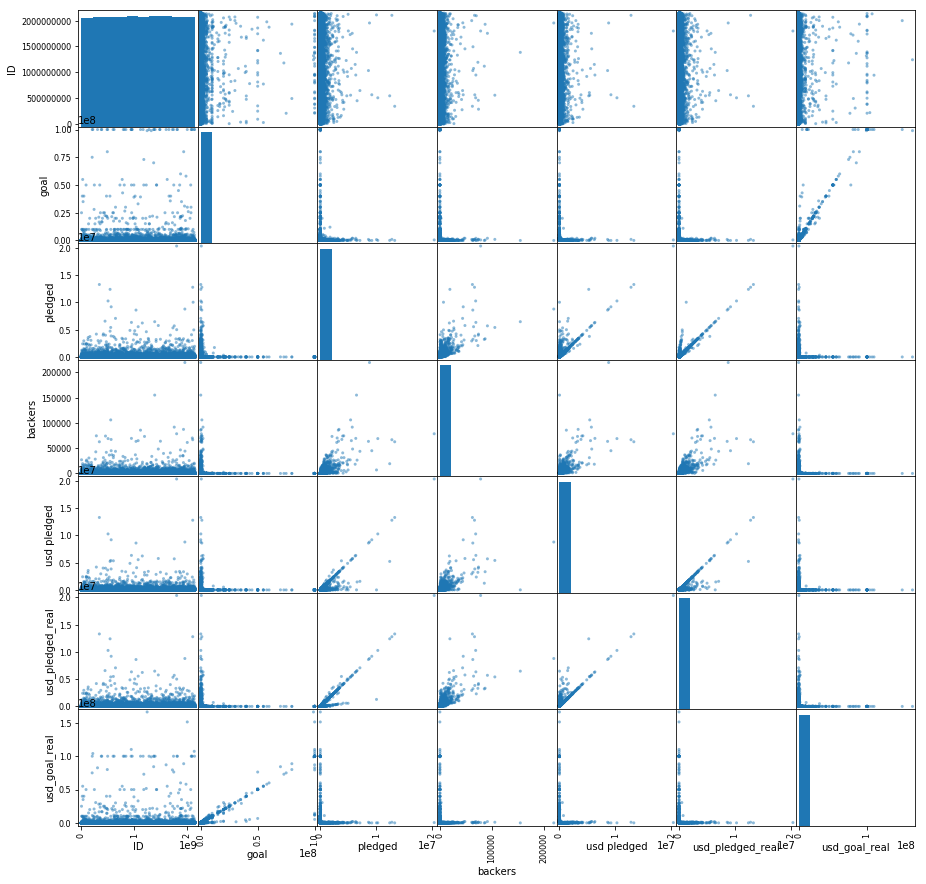

In [138]:
pd.plotting.scatter_matrix(df, figsize=(15,15))
plt.show()

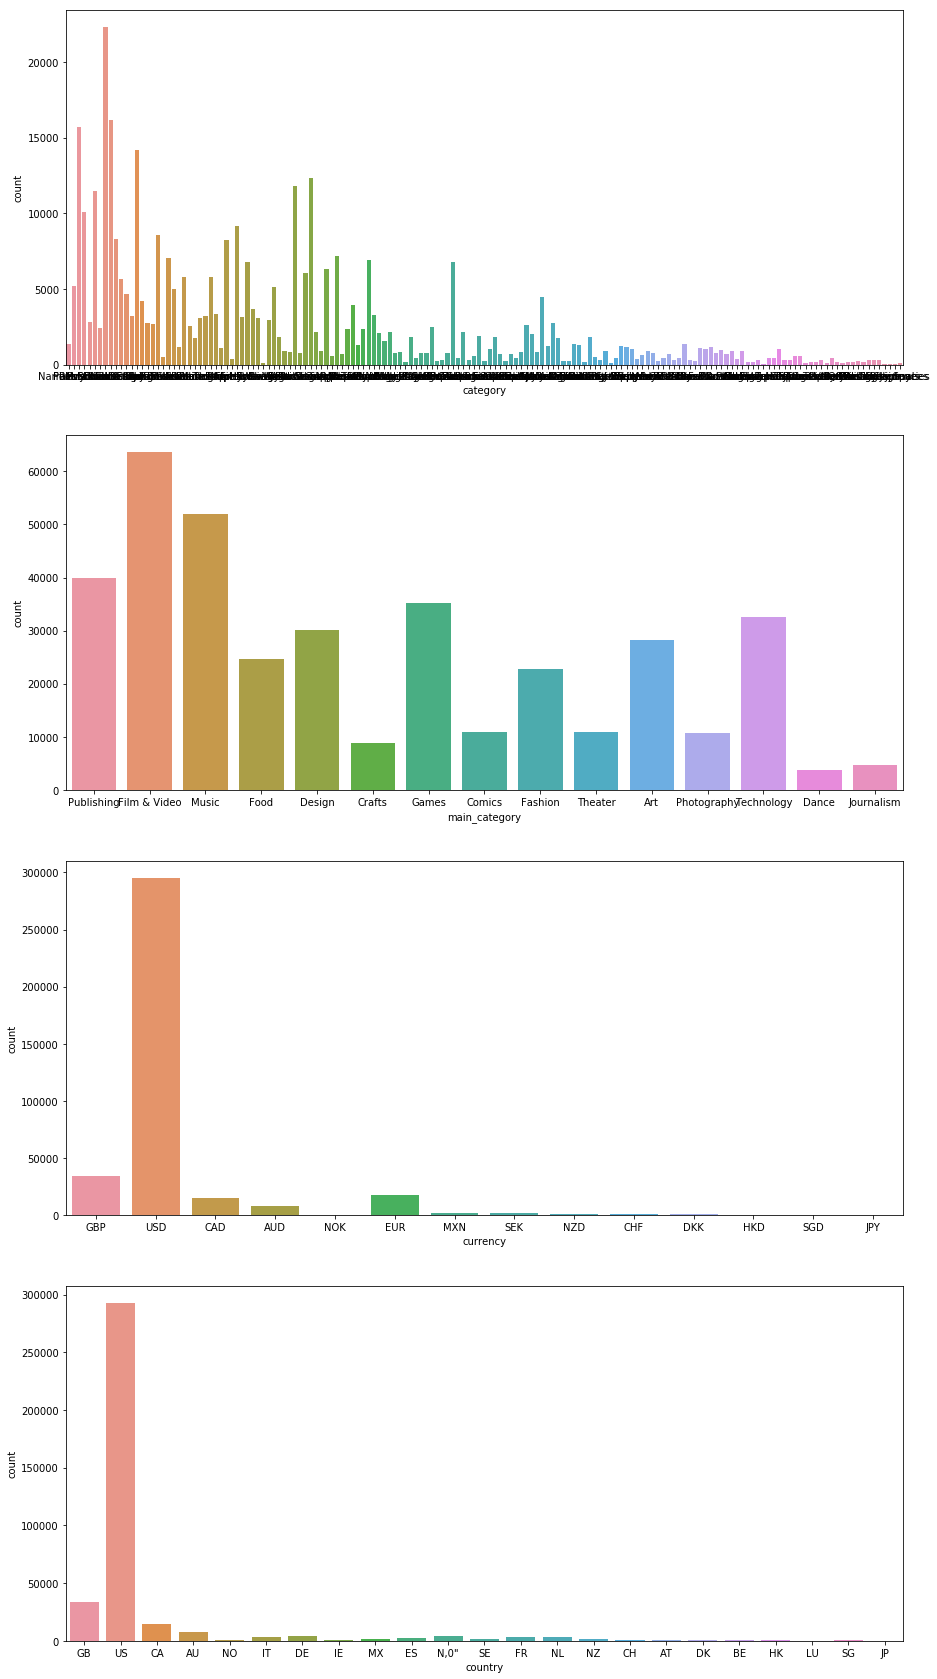

Product Design       22314
Documentary          16139
Music                15727
Tabletop Games       14180
Shorts               12357
Video Games          11830
Food                 11493
Film & Video         10108
Fiction               9169
Fashion               8554
Nonfiction            8318
Art                   8253
Apparel               7166
Theater               7057
Technology            6930
Rock                  6758
Children's Books      6756
Apps                  6345
Publishing            6018
Webseries             5762
Photography           5752
Indie Rock            5657
Narrative Film        5188
Web                   5153
Comics                4996
Crafts                4664
Country & Folk        4451
Design                4199
Hip-Hop               3912
Hardware              3663
                     ...  
Couture                275
Blues                  268
Animals                255
Fabrication Tools      250
Printing               238
Makerspaces            238
M

In [3]:
fig,ax = plt.subplots(4,1,figsize=(15,30))
sns.countplot(df.category,ax=ax[0])
sns.countplot(df.main_category,ax=ax[1])
sns.countplot(df.currency,ax=ax[2])
sns.countplot(df.country,ax=ax[3])
plt.show()
df.category.value_counts()

In [5]:
# 調査（Kickstarter本家サイトの利用者向け情報より）
- 「30日以下のプロジェクトは成功率が高い」⇒deadlineからlauncedを引いた値が有効そう。（https://www.kickstarter.com/help/handbook/funding?ref=handbook_rewards）
- 「一人当たりの平均的な支援額は25ドル」⇒活かし方は不明だが、一応メモしておく。（https://www.kickstarter.com/help/handbook/rewards?ref=handbook_story）


SyntaxError: invalid character in identifier (<ipython-input-5-bbc49b12a4fe>, line 2)

# 2. 作戦


## 作戦（DAY1）
- stateを推測する．
- usd_pledged_realを回帰で求めて，それをusd_goal_realと比較してstateを推測することとする．
    - 実際のstateの決まり方に従った形．
    - 私の業務ではロボットの制御をしたく，分類よりも回帰に興味があるため．
- 講座中に，successfulとfalse以外は省いて考えると良いとアドバイスがあったので従う．
- IDは使わない．
- 面白そうなnameは成功しそうだが、その解析は大変そう。とりあえず文字数が多ければ説明がしっかりしている、あるいは短ければシンプルで力強い、などの情報がありそうなので、文字数だけ使ってみる。
    - 山崎さんのアイデアのスペース数を単語数とみなして説明変数に加えるのを追加（DAY2）
- usd_pledged と usd_pledged_real はデータ例を見るとほぼ同じ値で，散布図行列でも45度の分布したデータが多い．ただ2番目のデータ例ではusd_pledged_realの方が正しそうであることと，usd_pledgedは比較的欠損値が多いことと，usd_goal_realと同じAPIで通貨変化をしているのがusd_pledged_realであることから，usd_pledgedは利用しない．（どっちが正しいかはより詳しい検証が必要かもしれない．）
- 通貨はすべて米ドルでそろえた方が比較しやすいので，米ドルで考える．
    - このためgoal, pledgedは見ない（Fixer.io APIの変換がうまくいっているかの検証を後で行う余裕があれば，そのために使うかも．）．
    - currencyは地域を反映するのに使えるが，それはcountryでわかるので，currencyは使わない．
- 日付はそのままでは解析しにくいので変換する．
    - 日付のままでは扱いにくいので2000年1月0日からの経過日数で表現する．（kickstarterの設立は2009年）
    - 年を追うごとにkickstarterが盛り上がっている可能性もあるか？
    - deadline - launchedで「公開日から締め切りまでの日数」に変換して考えることも考えたが，線形な変換なので不要と判断した．
        - 線形な変換でも無相関化に寄与するとわかったので，当該変換を加えた（DAY2）
    
## 作戦（DAY2での変更点）

DAY1ではまだ正答率が低かったので，改善したい．

DAY2の講座で汎化誤差の評価方法を習ったので，それを加味したい．

- countryはUSがほとんど．この場合のみで学習ができなければ，全部でもできない．まずはcountryはUSの場合だけで考える．
    - w^T x= 0 において，になっているダミー変数∈{0,1}にかけている重みは実質はカテゴリーごとにバイアス項を意味しているだけである．直線の傾きはダミー変数でない連続変数によって定められるが，これはすべての国に共通の値がつけられているので，カテゴリーごとにモデルを作るほうが自由度が高くなる．
- 似た考えで，categoryは Product Design が一番多いので，まずはcategory:Product Desin, main_category:Dsign の場合だけで考える．
- 変数間に相関があると良くないということだったので，明らかに相関が出るだろうdeadlineとlaunchedは扱いを考える．
    - 上記Kickstarterのサイトの調査結果からdeadline - launchedには価値があるようなので，これをproject_lengthとして新たな説明変数とする．
    - 無相関化は線形変換ということなので，線形変換で問題が解消する場合がある．つまり上記の差分を取るだけの線形な処理でもうまく動く可能性がある．
    - 年を追うごとにkickstarterが盛り上がっている可能性もあるので，どちらかは残す．（launchedを残した）
- 山崎さんがの，nameでスペース数を説明変数に使うアイデアを適用
- 単なる線形回帰でうまくいかなかったら，説明変数同士を掛け合わせた二次の項も作って説明変数に加えてみる．

## ここまでの変数のまとめ

|目標変数|説明変数|
|:---|:---|
|usd_pledged_real|name<br>deadline<br>launched<br>usd_goal_real|

使わない行：
- nameに欠損がある行
- countryがUS以外のデータ
- main_categoryがProduct Design以外のデータ

|列名|列名の意味|説明変数に使えるか？|目標変数に指定|説明変数に指定|備考|
|:---:|:---:|:---:|:---:|:---:|:---:|
|ID|ID|o|x|x|-|
|name|プロジェクト名|o|x|o|文字数と単語数（スペース数）を説明変数として利用|
|category|カテゴリー|o|x|-|Designだけを見る|
|main_category|メインカテゴリー|o|x|-|Product Designだけを見る|
|currency|プロジェクト通貨|o|x|x|countryと同様と考えた|
|deadline|締め切り|o|x|o|2000年1月0日からの日数に変換後，launchedとの差分を取った別の説明変数project_lengthに変更を検討|
|goal|目標額|o|x|x|usd_goal_realを利用|
|launched|公開日|o|x|o|2000年1月0日からの日数に変換．時刻は今は捨てる|
|pledged|支援額|x|x|x|-|
|state|成否|x|(o)|x|分類問題の目標変数であるが，回帰問題として考える中では使わない|
|backers|支援者数|x|x|x|-|
|country|国|o|x|-|とりあえずUSだけを見る|
|usd_pledged|支援額(\$)|x|x|x|usd_pledged_realの方を使う|
|usd_pledged_real|支援額(\$)|x|o|x|回帰の目標変数とする|
|usd_goal_real|目標額(\$)|o|x|o|-|



# 3. 前処理
- 使わない列を削除
- successfulとfalse以外のデータは捨てる
- countryがUSでないデータはとりあえず捨てる（そしてcountry列を削除） <---------- NEW
- categoryがProduct Designでないデータはとりあえず捨てる（そしてcategory列とmain_category列を削除） <---------- NEW
- nameに欠損値のあるデータはとりあえず捨てる
- nameを文字数に変換
- nameを単語数（スペース数）に変換
- deadlineとlaunchedを2000年1月0日からの日数に変換


In [4]:
# 使わない列を削除
df = df.drop(columns=["ID","currency","goal","pledged","backers","usd pledged"])


# successfulとfailed以外は除く
df = df[ (df["state"]=="successful") | (df["state"]=="failed") ]

# US以外は除く
df = df[ (df["country"]=="US") ]
# 使わない列を削除
df = df.drop(columns=["country"])

# main_categoryがFilm & Videoのもの以外は除く
#df = df[ (df["main_category"]=="Film & Video") ]
#df = df.drop(columns=["main_category"])

# categoryが Product Design 以外は除く
df = df[ df["category"]=="Product Design" ]
df = df.drop(columns=["category","main_category"])


# (name が)欠損しているデータを除く
df = df.dropna()

# successfulとfailed以外は除く
df = df[ (df["state"]=="successful") | (df["state"]=="failed") ]

# nameから文字数と単語数をカウントし，それぞれ説明変数にする．
df["name_len"] = df["name"].apply(len) # 文字数
df["name_words"] = df["name"].str.count(" ") # 単語数（≒スペース数）
df = df.drop(columns="name") # 元のname列を削除
    
# 日付を2000年1月0日からの経過日数に変換する関数を定義
# 面倒なのですべて1年は365日で，1月は30日として粗く変換
# 20yy-mm-dd を仮定
def date2days(s):
    y = int(s[2])*10 + int(s[3])
    m = int(s[5])*10 + int(s[6])
    d = int(s[8])*10 + int(s[9])
    days = y*365 + m*30 + d
    return days
# deadline
df["deadline_num"] = df["deadline"].apply(date2days)
df = df.drop(columns="deadline")
#launched
df["launched_num"] = df["launched"].apply(date2days)
df = df.drop(columns="launched")



## deadlineとlaunchedの相関
- 明らかにdeadlineとlaunchedには相関が予想される．
- 時期によって kichstarter の盛り上がりなどがあり得るので，プロジェクトが行われた時期は意味があると考えられる．
- 調査した通り，deadlineからlaunchedを引いた値は（プロジェクトの開始時期とは別で）意味があると考えられる．
-  deadline - lauchedが相関があるかどうかを調べる．

結果：
- 散布図行列を出してみたところ，deadlineとlaunchedには強い相関が見られた．
- 新しい説明変数project_lengthはdeadlineやlaunchedと相関が見られなかった．なので，deadlineを削除し，project_lengthを新たに使うこととする．

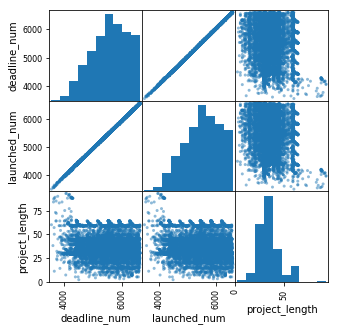

In [7]:
# deadlineからlaunchedを引いて募集期間 project_length 列を作成
df["project_length"] = df["deadline_num"].values - df["launched_num"].values

# 散布図行列により相関を確認
pd.plotting.scatter_matrix(df[["deadline_num","launched_num","project_length"]], figsize=(5,5))
plt.show()

In [8]:
# 使わない列を削除
df = df.drop(columns=["deadline_num"])

## 標準化

- とりあえず標準化をしてみると、usd_pledged_realとusd_goal_realがうまくいっていないように見えた．
- usd_pledged_realとusd_goal_realには先生にアドバイスいただいた対数変換を施してから標準化すると，それっぽくなってきた．

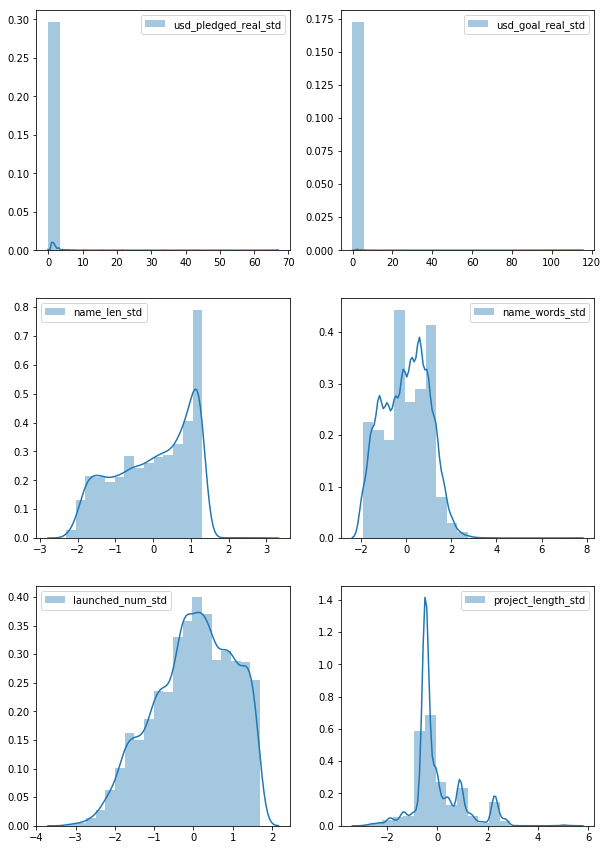

In [9]:
# 標準化をしてみる
stdsc = StandardScaler()
#df[["usd_pledged_real_std","usd_goal_real_std","name_len_std","deadline_num_std","launched_num_std"]] = stdsc.fit_transform(df[["usd_pledged_real","usd_goal_real","name_len","deadline_num","launched_num"]].values.astype(float))
df["usd_pledged_real_std"] = stdsc.fit_transform(df[["usd_pledged_real"]].values.astype(float))
df["usd_goal_real_std"] = stdsc.fit_transform(df[["usd_goal_real"]].values.astype(float))
df["name_len_std"] = stdsc.fit_transform(df[["name_len"]].values.astype(float))
df["name_words_std"] = stdsc.fit_transform(df[["name_words"]].values.astype(float))
df["launched_num_std"] = stdsc.fit_transform(df[["launched_num"]].values.astype(float))
df["project_length_std"] = stdsc.fit_transform(df[["project_length"]].values.astype(float))

fig,ax = plt.subplots(3,2,figsize=(10,15))
sns.distplot(df.usd_pledged_real_std.values,bins=20,ax=ax[0,0],label="usd_pledged_real_std")
sns.distplot(df.usd_goal_real_std.values,bins=20,ax=ax[0,1],label="usd_goal_real_std")
sns.distplot(df.name_len_std.values,bins=20,ax=ax[1,0],label="name_len_std")
sns.distplot(df.name_words_std.values,bins=20,ax=ax[1,1],label="name_words_std")
sns.distplot(df.launched_num_std.values,bins=20,ax=ax[2,0],label="launched_num_std")
sns.distplot(df.project_length_std.values,bins=20,ax=ax[2,1],label="project_length_std")
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
ax[2,0].legend()
ax[2,1].legend()
plt.show()


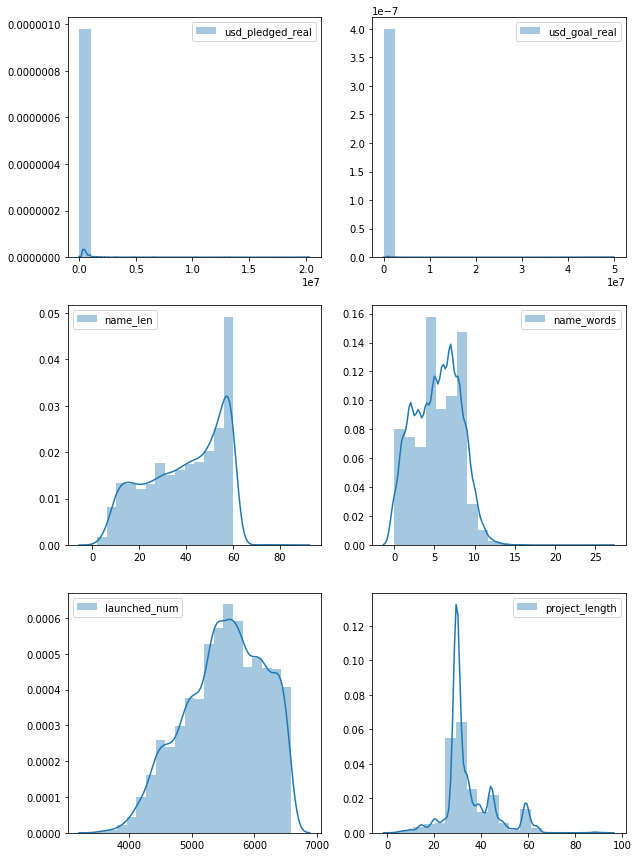

In [10]:
# 元の分布も見てみた
fig,ax = plt.subplots(3,2,figsize=(10,15))
sns.distplot(df.usd_pledged_real.values,bins=20,ax=ax[0,0],label="usd_pledged_real")
sns.distplot(df.usd_goal_real.values,bins=20,ax=ax[0,1],label="usd_goal_real")
sns.distplot(df.name_len.values,bins=20,ax=ax[1,0],label="name_len")
sns.distplot(df.name_words.values,bins=20,ax=ax[1,1],label="name_words")
sns.distplot(df.launched_num.values,bins=20,ax=ax[2,0],label="launched_num")
sns.distplot(df.project_length.values,bins=20,ax=ax[2,1],label="project_length")
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
ax[2,0].legend()
ax[2,1].legend()
plt.show()


## 金額関係の説明変数は対数変換してから標準化
先生にアドバイスしてもらった対数変換してから標準化する．
すると，それっぽくなった気がする．

In [11]:
df.usd_pledged_real.min() # log(0)は発散するので0があるか確認

0.0

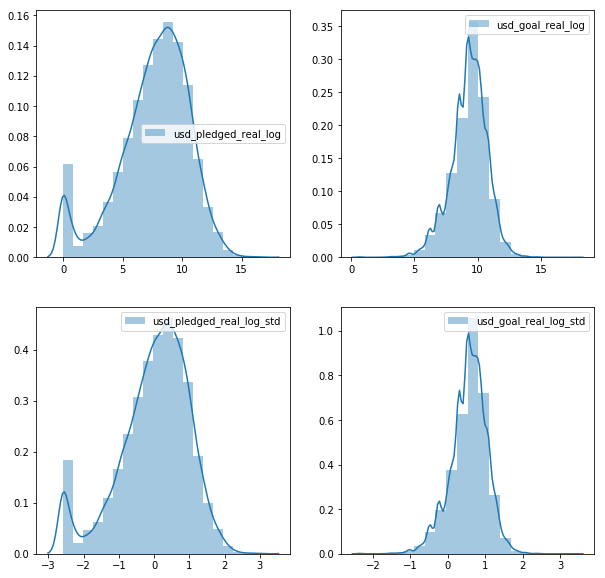

,name_len_std,name_words_std,launched_num_std,project_length_std,usd_pledged_real_log_std,usd_goal_real_log_std
count,1.373200e+04,1.373200e+04,1.373200e+04,1.373200e+04,1.373200e+04,13732.000000
mean,-1.363120e-16,9.055125e-18,-1.311336e-16,-1.680049e-16,-2.801793e-16,0.560613
std,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,0.479606
min,-2.314780e+00,-1.902651e+00,-3.228528e+00,-3.056229e+00,-2.578754e+00,-2.344826
25%,-8.215858e-01,-8.347378e-01,-7.094519e-01,-5.285074e-01,-5.268524e-01,0.295760
50%,1.738771e-01,2.331750e-01,7.536171e-02,-4.348881e-01,1.370182e-01,0.591181
75%,9.204742e-01,5.891459e-01,8.026330e-01,4.076858e-01,6.991528e-01,0.874488
max,2.849183e+00,7.352593e+00,1.692941e+00,5.463129e+00,3.100504e+00,3.404068


In [12]:
# 先生にアドバイスしてもらった対数変換してみる。
df["usd_pledged_real_log"] = (df["usd_pledged_real"]+1).apply(np.log) # log(0)を避けるため、1を足した
df["usd_goal_real_log"] = (df["usd_goal_real"]+1).apply(np.log) # 最後にpledgedとgoalを比較するため、前処理は同じにしたい。なので1を足す。

#df[["usd_pledged_real_log_std","usd_goal_real_std"]] = stdsc.fit_transform(df[["usd_pledged_real_log","usd_goal_real_log"]].values.astype(float))
df["usd_pledged_real_log_std"] = stdsc.fit_transform(df[["usd_pledged_real_log"]].values.astype(float))
df["usd_goal_real_log_std"] = stdsc.transform(df[["usd_goal_real_log"]].values.astype(float))


fig,ax = plt.subplots(2,2,figsize=(10,10))
sns.distplot(df.usd_pledged_real_log.values,bins=20,ax=ax[0,0],label="usd_pledged_real_log")
sns.distplot(df.usd_goal_real_log.values,bins=20,ax=ax[0,1],label="usd_goal_real_log")
sns.distplot(df.usd_pledged_real_log_std.values,bins=20,ax=ax[1,0],label="usd_pledged_real_log_std")
sns.distplot(df.usd_goal_real_log_std.values,bins=20,ax=ax[1,1],label="usd_goal_real_log_std")
#sns.distplot(df.name_len_std.values,bins=20,ax=ax[1,0])
#sns.distplot(df.deadline_num_std.values,bins=20,ax=ax[1,1])
#sns.distplot(df.launched_num_std.values,bins=20,ax=ax[2,0])
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
plt.show()

# 不要な列を削除
df = df.drop(columns=["usd_pledged_real","usd_pledged_real_std","usd_pledged_real_log","usd_goal_real","usd_goal_real_std","usd_goal_real_log","name_len","name_words","launched_num","project_length"])

display(df.describe())

## 前処理が終わったところで，もう一度，各種情報を見てみる．
- 散布図行列を見たところ残念ながら，usd_pledged_realとその他の説明変数に関連があるように見えない．．．
- プロジェクト名の長さや単語数，募集開始日，募集期間，目標金額だけで本当に金額を推定できるものか．．．？


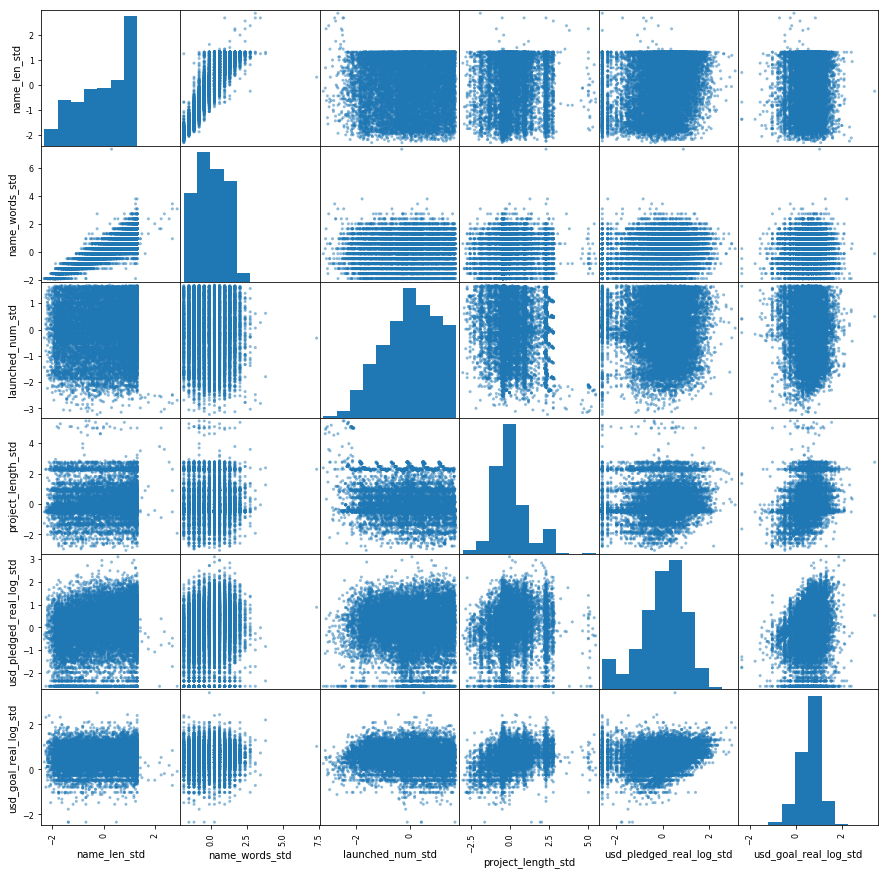

In [13]:

pd.plotting.scatter_matrix(df, figsize=(15,15))
plt.show()

In [14]:
display(df.info())
print(df.isnull().sum())
display(df.describe())
display(df.head(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13732 entries, 31 to 378644
Data columns (total 7 columns):
state                       13732 non-null object
name_len_std                13732 non-null float64
name_words_std              13732 non-null float64
launched_num_std            13732 non-null float64
project_length_std          13732 non-null float64
usd_pledged_real_log_std    13732 non-null float64
usd_goal_real_log_std       13732 non-null float64
dtypes: float64(6), object(1)
memory usage: 858.2+ KB


None

state                       0
name_len_std                0
name_words_std              0
launched_num_std            0
project_length_std          0
usd_pledged_real_log_std    0
usd_goal_real_log_std       0
dtype: int64


,name_len_std,name_words_std,launched_num_std,project_length_std,usd_pledged_real_log_std,usd_goal_real_log_std
count,1.373200e+04,1.373200e+04,1.373200e+04,1.373200e+04,1.373200e+04,13732.000000
mean,-1.363120e-16,9.055125e-18,-1.311336e-16,-1.680049e-16,-2.801793e-16,0.560613
std,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,0.479606
min,-2.314780e+00,-1.902651e+00,-3.228528e+00,-3.056229e+00,-2.578754e+00,-2.344826
25%,-8.215858e-01,-8.347378e-01,-7.094519e-01,-5.285074e-01,-5.268524e-01,0.295760
50%,1.738771e-01,2.331750e-01,7.536171e-02,-4.348881e-01,1.370182e-01,0.591181
75%,9.204742e-01,5.891459e-01,8.026330e-01,4.076858e-01,6.991528e-01,0.874488
max,2.849183e+00,7.352593e+00,1.692941e+00,5.463129e+00,3.100504e+00,3.404068


,state,name_len_std,name_words_std,launched_num_std,project_length_std,usd_pledged_real_log_std,usd_goal_real_log_std
31,successful,-0.386071,-0.478767,0.946489,-0.341269,1.053816,-0.247135
103,failed,-0.821586,-0.834738,1.016818,-0.528507,-0.872334,-0.480727
121,failed,0.796041,0.945117,-1.388771,0.033209,0.124755,1.382026
175,successful,-0.074989,0.233175,0.585251,0.501305,2.026468,1.231411
177,failed,-1.692616,-1.546680,0.052984,2.467311,-2.578754,0.512346
179,failed,1.293773,1.301088,0.347089,-0.528507,-0.320259,0.529655
186,successful,1.169340,0.945117,-0.217145,-0.809365,0.857349,0.295760
212,failed,-0.634936,-0.478767,0.104133,-0.528507,-2.578754,0.454355
234,successful,0.796041,0.233175,0.708327,-1.371081,-0.760010,-0.885485
238,failed,-1.257101,-1.546680,0.255981,0.875782,-0.061126,1.209630


ダミー変数化は不要．（その代わり，USのProduct Designしか扱わない．）

# 4. 学習と評価

usd_pledged_realを推定する線形モデルを学習し，その後，usd_goal_realと比較することで成否を判定．
- ホールドアウト法で汎化誤差を評価
- 前回と同じ線形回帰モデル，説明変数同士の積を計算して説明変数に加えた線形回帰モデル，より高次まで上げた多項式を考えた線形回帰モデルの3つを実施．

## 4.1 前回と同じ線形回帰モデル

結果：
- 訓練誤差と汎化誤差は大きく違わない．過学習ではない．
- 前回と正答率はあまり変わらないが再現率が劇的に下がった．

### 4.1.1 回帰モデル

In [15]:
y = df.usd_pledged_real_log_std.values
X = df.drop(['usd_pledged_real_log_std'], axis=1).values # 最後に分類問題の答え合わせをするのにstateがどこか分からないといけないので，とりあえずここに入れておく．
#X = df.drop(['usd_pledged_real_log_std',"state"], axis=1).values

# ホールドアウト法
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

In [16]:
# usd_pledged_realを推定する重回帰モデルを作成
model = LinearRegression(fit_intercept=True)
model.fit(X_train[:,1:], y_train) # 0列目はstate

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数

# 値を予測
y_train_pred = model.predict(X_train[:,1:]) # 0列目はstate
y_test_pred  = model.predict(X_test[:,1:]) # 0列目はstate

# MSE, MAE, RMSEを計算
mse_train = mean_squared_error(y_train, y_train_pred) 
mae_train = mean_absolute_error(y_train, y_train_pred) 
rmse_train = np.sqrt(mse_train)
print("MSE(train) = %s"%round(mse_train,3) )  
print("MAE(trian) = %s"%round(mae_train,3) )
print("RMSE(train) = %s"%round(rmse_train, 3) )
mse_test = mean_squared_error(y_test, y_test_pred) 
mae_test = mean_absolute_error(y_test, y_test_pred) 
rmse_test = np.sqrt(mse_test)
print("MSE(test) = %s"%round(mse_test,3) )  
print("MAE(test) = %s"%round(mae_test,3) )
print("RMSE(test) = %s"%round(rmse_test, 3) )



MSE(train) = 0.896
MAE(trian) = 0.736
RMSE(train) = 0.947
MSE(test) = 0.928
MAE(test) = 0.751
RMSE(test) = 0.963


### 4.1.2 推定したusd_pledged_realと与えられたデータusd_goal_realを比較して，成否を推定

In [18]:
# 回帰モデルの結果y_predとusd_goal_realを比較して成否を判定（前処理をそろえているのでそのまま比較可能）
y2_train_pred = np.where( y_train_pred >= X_train[:,5], True, False ) # Xの5列目が usd_goal_real
y2_test_pred = np.where( y_test_pred >= X_test[:,5], True, False ) # Xの5列目が usd_goal_real


# 正解データをブール型に加工
y2_train = np.where( X_train[:,0]=="successful", True, False )
y2_test  = np.where( X_test[:,0]=="successful", True, False )

In [19]:
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数

print("訓練誤差")
# 正答率を計算
accuracy_train =  accuracy_score(y2_train, y2_train_pred)
print('正答率（Accuracy） = {:.3%}'.format(accuracy_train))
# Precision, Recall, F1-scoreを計算
precision_train, recall_train, f1_score_train, _ = precision_recall_fscore_support(y2_train, y2_train_pred)
# カテゴリ「成功」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3%}'.format(precision_train[1]))
print('再現率（Recall） = {:.3%}'.format(recall_train[1]))
print('F1値（F1-score） = {:.3%}'.format(f1_score_train[1]))
# 予測値と正解のクロス集計
conf_mat_train = pd.DataFrame(confusion_matrix(y2_train, y2_train_pred), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
display(conf_mat_train)

#################################################################################
print("汎化誤差")
# 正答率を計算
accuracy_test =  accuracy_score(y2_test, y2_test_pred)
print('正答率（Accuracy） = {:.3%}'.format(accuracy_test))
# Precision, Recall, F1-scoreを計算
precision_test, recall_test, f1_score_test, _ = precision_recall_fscore_support(y2_test, y2_test_pred)
# カテゴリ「成功」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3%}'.format(precision_test[1]))
print('再現率（Recall） = {:.3%}'.format(recall_test[1]))
print('F1値（F1-score） = {:.3%}'.format(f1_score_test[1]))
# 予測値と正解のクロス集計
conf_mat_test = pd.DataFrame(confusion_matrix(y2_test, y2_test_pred), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
display(conf_mat_test)



訓練誤差
正答率（Accuracy） = 59.345%
適合率（Precision） = 69.340%
再現率（Recall） = 8.307%
F1値（F1-score） = 14.836%


,予測 = failed,予測 = successful
正解 = failed,6130,172
正解 = successful,4294,389


汎化誤差
正答率（Accuracy） = 59.519%
適合率（Precision） = 65.035%
再現率（Recall） = 8.052%
F1値（F1-score） = 14.330%


,予測 = failed,予測 = successful
正解 = failed,1542,50
正解 = successful,1062,93


### 4.1.3 線形モデルでの結果
#### DAY1
- 正答率・再現率は59%であるが，適合率は50%であった．あてずっぽうよりは少しだけ当たっている程度という印象であった．
- usd_pledged_realの推定のMAEは14000ドル程度であり大きいようにも感じるが，正解データのSTDが90000ドル程度あるのでそう悪くないのか？

#### DAY2
- 正答率は59%．カテゴリーや国を絞ったのに，正答率は変わらず，再現率はDAY1より悪化した．
- 依然アンダーフィッティング状態とみられる．

|　|DAY1|DAY2(訓練データ)|DAY2(テストデータ)|
|:---|:---|:---|:---|
|正答率|59.1%|59.1%|59.0%|
|適合率|49.5%|69.4%|65.0%|
|再現率|58.9%|7.4%|5.6%|
|F1値|53.8%|13.3%|10.4%|


## 4.2 説明変数同士を掛け合わせた二次の項を説明変数に加えた線形回帰

結果：4.1の通常の線形モデルとあまり変わらなかった．

In [20]:
df.head()

,state,name_len_std,name_words_std,launched_num_std,project_length_std,usd_pledged_real_log_std,usd_goal_real_log_std
31,successful,-0.386071,-0.478767,0.946489,-0.341269,1.053816,-0.247135
103,failed,-0.821586,-0.834738,1.016818,-0.528507,-0.872334,-0.480727
121,failed,0.796041,0.945117,-1.388771,0.033209,0.124755,1.382026
175,successful,-0.074989,0.233175,0.585251,0.501305,2.026468,1.231411
177,failed,-1.692616,-1.546680,0.052984,2.467311,-2.578754,0.512346


In [21]:
# 二次の項を作成
df["name_len-name_len"  ]  = df["name_len_std"].values * df["name_len_std"].values
df["name_len-name_words"]  = df["name_len_std"].values * df["name_words_std"].values
df["name_len-launched"]    = df["name_len_std"].values * df["launched_num_std"].values
df["name_len-project_len"] = df["name_len_std"].values * df["project_length_std"].values
df["name_len-goal"]        = df["name_len_std"].values * df["usd_goal_real_log_std"].values
df["name_words-name_words"]  = df["name_words_std"].values * df["name_words_std"].values
df["name_words-launched"]    = df["name_words_std"].values * df["launched_num_std"].values
df["name_words-project_len"] = df["name_words_std"].values * df["project_length_std"].values
df["name_words-goal"]        = df["name_words_std"].values * df["usd_goal_real_log_std"].values
df["launched-launched"]    = df["launched_num_std"].values * df["launched_num_std"].values
df["launched-project_len"] = df["launched_num_std"].values * df["project_length_std"].values
df["launched-goal"]        = df["launched_num_std"].values * df["usd_goal_real_log_std"].values
df["project_len-project_len"] = df["project_length_std"].values * df["project_length_std"].values
df["project_len-goal"]        = df["project_length_std"].values * df["usd_goal_real_log_std"].values
df["goal-goal"]        = df["usd_goal_real_log_std"].values * df["usd_goal_real_log_std"].values

y = df.usd_pledged_real_log_std.values
X = df.drop(['usd_pledged_real_log_std'], axis=1).values # 最後に分類問題の答え合わせをするのにstateがどこか分からないといけないので，とりあえずここに入れておく．



# ホールドアウト法
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

In [22]:
# usd_pledged_realを推定する重回帰モデルを作成
model = LinearRegression(fit_intercept=True)
model.fit(X_train[:,1:], y_train) # 0列目はstate

# 値を予測
y_train_pred = model.predict(X_train[:,1:]) # 0列目はstate
y_test_pred  = model.predict(X_test[:,1:]) # 0列目はstate

# MSE, MAE, RMSEを計算
mse_train = mean_squared_error(y_train, y_train_pred) 
mae_train = mean_absolute_error(y_train, y_train_pred) 
rmse_train = np.sqrt(mse_train)
print("MSE(train) = %s"%round(mse_train,3) )  
print("MAE(trian) = %s"%round(mae_train,3) )
print("RMSE(train) = %s"%round(rmse_train, 3) )
mse_test = mean_squared_error(y_test, y_test_pred) 
mae_test = mean_absolute_error(y_test, y_test_pred) 
rmse_test = np.sqrt(mse_test)
print("MSE(test) = %s"%round(mse_test,3) )  
print("MAE(test) = %s"%round(mae_test,3) )
print("RMSE(test) = %s"%round(rmse_test, 3) )

MSE(train) = 0.862
MAE(trian) = 0.722
RMSE(train) = 0.928
MSE(test) = 0.887
MAE(test) = 0.734
RMSE(test) = 0.942


In [23]:
# 回帰モデルの結果y_predとusd_goal_realを比較して成否を判定（前処理をそろえているのでそのまま比較可能）
y2_train_pred = np.where( y_train_pred >= X_train[:,5], True, False ) # Xの5列目が usd_goal_real
y2_test_pred = np.where( y_test_pred >= X_test[:,5], True, False ) # Xの5列目が usd_goal_real

# 正解データをブール型に加工
y2_train = np.where( X_train[:,0]=="successful", True, False )
y2_test  = np.where( X_test[:,0]=="successful", True, False )

#################################################################################
print("訓練誤差")
# 正答率を計算
accuracy_train =  accuracy_score(y2_train, y2_train_pred)
print('正答率（Accuracy） = {:.3%}'.format(accuracy_train))
# Precision, Recall, F1-scoreを計算
precision_train, recall_train, f1_score_train, _ = precision_recall_fscore_support(y2_train, y2_train_pred)
# カテゴリ「成功」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3%}'.format(precision_train[1]))
print('再現率（Recall） = {:.3%}'.format(recall_train[1]))
print('F1値（F1-score） = {:.3%}'.format(f1_score_train[1]))
# 予測値と正解のクロス集計
conf_mat_train = pd.DataFrame(confusion_matrix(y2_train, y2_train_pred), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
display(conf_mat_train)
#################################################################################
print("汎化誤差")
# 正答率を計算
accuracy_test =  accuracy_score(y2_test, y2_test_pred)
print('正答率（Accuracy） = {:.3%}'.format(accuracy_test))
# Precision, Recall, F1-scoreを計算
precision_test, recall_test, f1_score_test, _ = precision_recall_fscore_support(y2_test, y2_test_pred)
# カテゴリ「成功」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3%}'.format(precision_test[1]))
print('再現率（Recall） = {:.3%}'.format(recall_test[1]))
print('F1値（F1-score） = {:.3%}'.format(f1_score_test[1]))
# 予測値と正解のクロス集計
conf_mat_test = pd.DataFrame(confusion_matrix(y2_test, y2_test_pred), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
display(conf_mat_test)

訓練誤差
正答率（Accuracy） = 59.126%
適合率（Precision） = 69.416%
再現率（Recall） = 7.367%
F1値（F1-score） = 13.320%


,予測 = failed,予測 = successful
正解 = failed,6150,152
正解 = successful,4338,345


汎化誤差
正答率（Accuracy） = 59.046%
適合率（Precision） = 65.000%
再現率（Recall） = 5.628%
F1値（F1-score） = 10.359%


,予測 = failed,予測 = successful
正解 = failed,1557,35
正解 = successful,1090,65


### 結果
2次の項を考えても，正答率はほとんど向上しなかった．

## 4.3 もっと高次の多項式を考える．
結果：七次までやっただ，あまり変わらなかった．

### 回帰モデルの学習と評価

In [24]:
# 上で作った2次の項を消す
df = df.drop(columns=["name_len-name_len","name_len-name_words","name_len-launched","name_len-project_len","name_len-goal",
                      "name_words-name_words","name_words-launched","name_words-project_len","name_words-goal",
                     "launched-launched","launched-project_len","launched-goal",
                     "project_len-project_len","project_len-goal","goal-goal"])
y = df.usd_pledged_real_log_std.values
X = df.drop(['usd_pledged_real_log_std'], axis=1).values # 最後に分類問題の答え合わせをするのにstateがどこか分からないといけないので，とりあえずここに入れておく．

# ホールドアウト法
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

# 学習
degree = 7
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X[:,1:], y)# 0列目はstate

# 値を予測
y_train_pred = model.predict(X_train[:,1:]) # 0列目はstate
y_test_pred  = model.predict(X_test[:,1:]) # 0列目はstate

# MSE, MAE, RMSEを計算
mse_train = mean_squared_error(y_train, y_train_pred) 
mae_train = mean_absolute_error(y_train, y_train_pred) 
rmse_train = np.sqrt(mse_train)
print("MSE(train) = %s"%round(mse_train,3) )  
print("MAE(trian) = %s"%round(mae_train,3) )
print("RMSE(train) = %s"%round(rmse_train, 3) )
mse_test = mean_squared_error(y_test, y_test_pred) 
mae_test = mean_absolute_error(y_test, y_test_pred) 
rmse_test = np.sqrt(mse_test)
print("MSE(test) = %s"%round(mse_test,3) )  
print("MAE(test) = %s"%round(mae_test,3) )
print("RMSE(test) = %s"%round(rmse_test, 3) )

MSE(train) = 0.772
MAE(trian) = 0.68
RMSE(train) = 0.878
MSE(test) = 0.788
MAE(test) = 0.69
RMSE(test) = 0.888


それほど効果がなかった．

### 分類

In [25]:
# 回帰モデルの結果y_predとusd_goal_realを比較して成否を判定（前処理をそろえているのでそのまま比較可能）
y2_train_pred = np.where( y_train_pred >= X_train[:,5], True, False ) # Xの5列目が usd_goal_real
y2_test_pred = np.where( y_test_pred >= X_test[:,5], True, False ) # Xの5列目が usd_goal_real

# 正解データをブール型に加工
y2_train = np.where( X_train[:,0]=="successful", True, False )
y2_test  = np.where( X_test[:,0]=="successful", True, False )

#################################################################################
print("訓練誤差")
# 正答率を計算
accuracy_train =  accuracy_score(y2_train, y2_train_pred)
print('正答率（Accuracy） = {:.3%}'.format(accuracy_train))
# Precision, Recall, F1-scoreを計算
precision_train, recall_train, f1_score_train, _ = precision_recall_fscore_support(y2_train, y2_train_pred)
# カテゴリ「成功」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3%}'.format(precision_train[1]))
print('再現率（Recall） = {:.3%}'.format(recall_train[1]))
print('F1値（F1-score） = {:.3%}'.format(f1_score_train[1]))
# 予測値と正解のクロス集計
conf_mat_train = pd.DataFrame(confusion_matrix(y2_train, y2_train_pred), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
display(conf_mat_train)
#################################################################################
print("汎化誤差")
# 正答率を計算
accuracy_test =  accuracy_score(y2_test, y2_test_pred)
print('正答率（Accuracy） = {:.3%}'.format(accuracy_test))
# Precision, Recall, F1-scoreを計算
precision_test, recall_test, f1_score_test, _ = precision_recall_fscore_support(y2_test, y2_test_pred)
# カテゴリ「成功」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3%}'.format(precision_test[1]))
print('再現率（Recall） = {:.3%}'.format(recall_test[1]))
print('F1値（F1-score） = {:.3%}'.format(f1_score_test[1]))
# 予測値と正解のクロス集計
conf_mat_test = pd.DataFrame(confusion_matrix(y2_test, y2_test_pred), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
display(conf_mat_test)

訓練誤差
正答率（Accuracy） = 61.147%
適合率（Precision） = 75.523%
再現率（Recall） = 13.111%
F1値（F1-score） = 22.344%


,予測 = failed,予測 = successful
正解 = failed,6103,199
正解 = successful,4069,614


汎化誤差
正答率（Accuracy） = 60.903%
適合率（Precision） = 72.376%
再現率（Recall） = 11.342%
F1値（F1-score） = 19.611%


,予測 = failed,予測 = successful
正解 = failed,1542,50
正解 = successful,1024,131


### 結果
7次まで考えても正答率はほとんど向上しなかった．
8次ではメモリエラーが出た．

|　|DAY1|DAY2(一次，訓練データ)|DAY2(一次，テストデータ)|DAY2(七次，テストデータ)|
|:---|:---|:---|:---|:---|
|正答率|59.1%|59.1%|59.0%|60.9%|
|適合率|49.5%|69.4%|65.0%|72.3%|
|再現率|58.9%|7.4%|5.6%|11.3%|
|F1値|53.8%|13.3%|10.4%|19.6%|


# 5 結論
国やカテゴリーを固定することで性能の高いモデルを作ろうとしたが，正答率は向上せず，制限率が劇的に下がった．
説明変数を掛け合わせた高次項を作ってみたが，同様であった．